In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-recommendation-data/lthing_data/lthing_data/reviews.txt
/kaggle/input/social-recommendation-data/lthing_data/lthing_data/edges.txt
/kaggle/input/social-recommendation-data/epinions_data/epinions_data/network_trust.txt
/kaggle/input/social-recommendation-data/epinions_data/epinions_data/network_trustedby.txt
/kaggle/input/social-recommendation-data/epinions_data/epinions_data/epinions.txt


In [2]:
import numpy 
import surprise
print(f"Numpy Version: {numpy.__version__}")
print(f"Surprise Version: {surprise.__version__}")

Numpy Version: 1.26.4
Surprise Version: 1.1.4


# Data Loading

In [3]:
import os

s = ''
with open('/kaggle/input/social-recommendation-data/lthing_data/lthing_data/reviews.txt') as file:
    s = file.read()
    s = s.split('\n')
    print(len(s))
    s = s[1:500000]

1707072


In [4]:
reviews_file = '/kaggle/input/social-recommendation-data/lthing_data/lthing_data/reviews.txt'

In [5]:
with open(reviews_file, 'r') as file:
    for _ in range(3):  
        print(file.readline())

reviews = {}

reviews[('73960', 'Elizabeth.Wong98')] = {'comment': "Every evening, the brave queen of Persia, Shahrazad, goes into the Sultan's rooms and begins a weave of words, hoping to entice the Sultan to let her live another night so she can continue her story. But Shahrazad has a big problem: She is running out of stories. With a delicate stroke of luck, a cripple girl, Marjan, ventures into the harem with her Aunt to sell various wares. As her Aunt is selling things, Marjan entertains some of the children with a story. Unbeknownst to Marjan, Shahrazad's sister, Dunyazad, has heard her telling the story. Marjan is taken directly to Shahrazad and asked to recount the story. The tale keeps the queen alive another night and the queen decides to keep Marjan.\n As her helper, Marjan has to go into the city and look for tales that the Sultan has not heard. She has several close calls with the Kathun, the voracious female who rules the harem and who is set against \nShahrazad. Finally 

In [6]:
# for key, value in list(reviews.items())[:5]:
#     print(f"Key: {key}, Value: {value}")
#     print("------------")

## Data Formatting

In [ ]:
import ast
import pandas as pd

# Initialize an empty list to store review data
data = []

with open(reviews_file, 'r') as file:
    for line in file:
        if line.strip().startswith("reviews["):  # Skip lines assigning 'reviews'
            key_value = line.strip().split(" = ", 1)[1]  # Extract dictionary part
            review_entry = ast.literal_eval(key_value)
            data.append(review_entry)

# Convert the list of dictionaries directly into a DataFrame
reviews_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(reviews_df.head())

In [ ]:
reviews_df

In [ ]:
# Save the DataFrame to a CSV file
reviews_df[:10].to_csv('/kaggle/working/reviews_processed10.csv', index=False)

In [ ]:
edges_file = '/kaggle/input/social-recommendation-data/lthing_data/lthing_data/edges.txt'

In [ ]:
with open(edges_file, 'r') as file:
    for _ in range(3):  
        print(file.readline())

In [ ]:
# Load edges into a DataFrame
edges_data = []
with open(edges_file, 'r') as file:
    for line in file:
        users = line.strip().split()  # Split by whitespace to get the two usernames
        if len(users) == 2:  # Ensure only valid pairs
            edges_data.append(users)

edges_df = pd.DataFrame(edges_data, columns=['user1', 'user2'])

In [ ]:
edges_df

In [ ]:
merged_df = edges_df.merge(reviews_df, left_on='user1', right_on='user', how='left')

# Display merged data
print(merged_df.head())

In [ ]:
# # Save the merged data if needed
# merged_df.to_csv('/kaggle/working/merged_edges_reviews.csv', index=False)
# # Save the merged data if needed
merged_df[:10].to_csv('/kaggle/working/merged_edges_reviews_10.csv', index=False)

# EDA

In [ ]:
connection_counts = edges_df['user1'].value_counts()
print(connection_counts.head(10))  # Top 10 users with the most connections

In [ ]:
#Review Sentiment by Network
avg_rating_per_user = merged_df.groupby('user1')['stars'].mean().reset_index()
avg_rating_per_user.columns = ['user1', 'avg_rating']
print(avg_rating_per_user.head())

In [ ]:
helpful_votes_per_user = merged_df.groupby('user1')['nhelpful'].sum().reset_index()
helpful_votes_per_user.columns = ['user1', 'total_helpful_votes']
print(helpful_votes_per_user.sort_values(by='total_helpful_votes', ascending=False).head())

In [ ]:
import networkx as nx
# Create a graph from edges
G = nx.from_pandas_edgelist(edges_df, source='user1', target='user2')

# Find centrality measures (influential users)
degree_centrality = nx.degree_centrality(G)
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])  # Top 10 influential users

In [ ]:
import matplotlib.pyplot as plt
reviews_df['stars'].hist(bins=10)
plt.title('Review Stars Distribution')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.show()

In [ ]:
merged_df['review_date'] = pd.to_datetime(merged_df['unixtime'], unit='s')
review_activity = merged_df.groupby(merged_df['review_date'].dt.date).size()
review_activity.plot(kind='line', title='Review Activity Over Time', xlabel='Date', ylabel='Number of Reviews')
plt.show()

# Analysis/ Interpretation

1. Top Users by Connections:        
*  Most Connected Users: The users theoldman, rolandperkins, and gangleri have the highest number of social connections.These users are likely central figures in the social network, suggesting they interact widely or have substantial influence.          

2. User Review Behavior: 
* Average Ratings by User:    The users show varying average ratings, reflecting different reviewing tendencies.    Users like -HarryH- (average rating 4.5) tend to give higher ratings, indicating they either enjoy most works or are lenient reviewers.
* Helpful Votes:    Users such as richardderus and Whisper1 have accumulated a significant number of helpful votes, indicating their reviews are widely read and considered useful by others.
  These users might be considered thought leaders in the community.                     
3. Network Centrality
* Degree Centrality:Users like theoldman, rolandperkins, and Smethers are influential within the social graph, with high centrality scores. They likely act as hubs, bridging multiple smaller user groups.

4. Review Star Distribution 
* The histogram shows that most reviews are positive, with many 4- and 5-star ratings.This indicates that users are generally satisfied with the works they are reviewing, or there may be some bias towards positive reviews.

5. Review Activity Over Time 
* The sharp increase in review activity from around 2005 to 2015 suggests the platform gained significant traction during this period.The early low-frequency activity might indicate either fewer users or missing data from earlier years.



# Data preprocessing

In [ ]:
reviews_df.head()

## User-Item

In [ ]:
# Check for missing values
print(reviews_df.isnull().sum())

In [ ]:
# Fill missing values in stars with the median rating (or other strategies depending on analysis)
reviews_df['stars'].fillna(reviews_df['stars'].median(), inplace=True)


# # Drop rows with missing comments, as they are essential for sentiment analysis
# reviews_df.dropna(subset=['comment'], inplace=True)


# 1. Get stars from comments to fill the missing values .....
# 2. Use median as another strategy
# 3. Use weighted average of both

<!-- 
# 1. Get stars from comments to fill the missing values .....
# 2. Use median as another strategy
# 3. Use weighted average of both -->

In [ ]:
reviews_df.dropna(subset=['unixtime', 'time'], inplace=True)

In [ ]:
# Check for missing values
print(reviews_df.isnull().sum())

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding user and work columns
user_encoder = LabelEncoder()
reviews_df['user_encoded'] = user_encoder.fit_transform(reviews_df['user'])

work_encoder = LabelEncoder()
reviews_df['work_encoded'] = work_encoder.fit_transform(reviews_df['work'])

## Feature Engineering

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

# Adding sentiment polarity as a new feature
reviews_df['sentiment'] = reviews_df['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
reviews_df['review_date'] = pd.to_datetime(reviews_df['unixtime'], unit='s')
reviews_df['year'] = reviews_df['review_date'].dt.year
reviews_df['month'] = reviews_df['review_date'].dt.month

In [ ]:
reviews_df['year'].unique()

In [ ]:
reviews_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data for collaborative filtering (using user-item interactions)
X = reviews_df[['user_encoded', 'work_encoded', 'year', 'month']]
y = reviews_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Collabarative Filtering

In [ ]:
!pip install scikit-surprise


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

## Time decay 

In [ ]:
# Import necessary modules
import numpy as np

def time_decay(review_date, current_date, max_days=30):
    days_diff = (current_date - review_date).days
    return max(1 - (days_diff / max_days), 0)  # Linear decay: 0 weight after max_days


reviews_df['review_date'] = pd.to_datetime(reviews_df['unixtime'], unit='s')

# Set current date to the most recent review in the dataset
current_date = reviews_df['review_date'].max()

# Apply the time decay function
reviews_df['time_decay'] = reviews_df['review_date'].apply(lambda x: time_decay(x, current_date))

# Adjust the ratings using the time decay factor
reviews_df['adjusted_stars'] = reviews_df['stars'] * reviews_df['time_decay']
reviews_df['final_stars'] = 0.5 * reviews_df['stars'] + 0.5 * reviews_df['adjusted_stars']

In [ ]:
reviews_df.head()

In [ ]:
reviews_df[:1000].to_csv("reviews_processed_time.csv")

## SVD

In [ ]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Prepare data for Surprise
data = Dataset.load_from_df(reviews_df[['user_encoded', 'work_encoded', 'final_stars']], reader=reader)

# Train-test split
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Use SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Predictions
predictions = svd_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
print(f"RMSE of the collaborative filtering model with time decay factor: {rmse:.4f}")

## Hyper Parameter tuning

In [ ]:
from surprise.model_selection import GridSearchCV

# param_grid = {
#     'n_factors': [50, 100, 150],
#     'lr_all': [0.002, 0.005, 0.01],
#     'reg_all': [0.02, 0.05, 0.1]
# }

# gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# gs.fit(data)

# print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
# print(f"Best Parameters: {gs.best_params['rmse']}")

In [ ]:
pd.DataFrame(predictions).to_csv("Basic_SVD.csv")

## Save Model

In [ ]:
print("hello")

In [65]:
import pickle

# Save the model to a file
with open('svd_model.pkl', 'wb') as file:
    print("saving......")
    pickle.dump(svd_model, file)

saving......



* Try Hybrid decay approach
* Apply Dynamic time decay


In [64]:
print(f"Numpy Version: {numpy.__version__}")
print(f"Surprise Version: {surprise.__version__}")

Numpy Version: 1.26.4
Surprise Version: 1.1.4


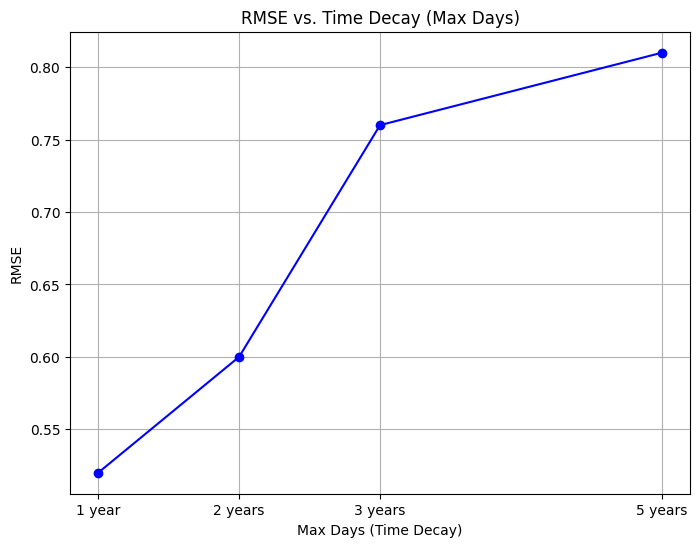

In [6]:
import matplotlib.pyplot as plt

# Data for different max_days and corresponding RMSE values
max_days_values = [365*5, 365*3, 365*2, 365]  # 5 years, 2 years, 1 year, 30 days
rmse_values = [0.81, 0.76, 0.60, 0.52]  # RMSE for each max_days value

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(max_days_values, rmse_values, marker='o', linestyle='-', color='b')

# Set plot labels and title
plt.xlabel("Max Days (Time Decay)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Time Decay (Max Days)")

# Set X-axis to show the values clearly
plt.xticks([365*5, 365*3, 365*2, 365], ['5 years', '3 years', '2 years', '1 year'])

# Display the plot
plt.grid(True)
plt.show()
